The example below uses scikit-image library to detect circular features in farms using center pivot irrigation in Saudi Arabia. It then counts and reports the number of farms. This is one of the ways in which libraries from the scientific Python ecosystem can be integrated with the ArcGIS platform.

It uses the Multispectral Landsat imagery available at ArcGIS Online.

Note: to run this sample, you need a few extra libraries in your conda environment. If you don't have the libraries, install them by running the following commands from cmd.exe or your shell

- conda install scipy
- conda install matplotlib
- conda install scikit-image

In [1]:
!pip install arcgis

     |████████████████████████████████| 2.0MB 2.7MB/s 
  Using cached https://files.pythonhosted.org/packages/53/14/1c952bcd21255f42f9ba0280d3abd8074dca2c27d136eb749b98ab478f72/keyring-21.5.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f2/20/73c8fa29a4ba8f8cbdb037369e6b61ac9253664a8aa0912b52169192447f/lerc-0.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/31/7b/cd66f306c31a84a53c6a3a86e296586e8664f407a6ac5b7cfe6a433aa8c4/jupyterlab-2.2.9-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ca/1f/e9cc2c3fce32e2926581f8b6905831165235464c858ba550b6e9b8ef78c3/pyshp-2.1.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/60/ef/7681134338fc097acef8d9b2f8abe0458e4d87559c689a8c306d0957ece5/requests_toolbelt-0.9.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/03/4b/8b9a1afde8072c4d5710d9fa91433d504325821b038e00237dc8d6d833dc/requests_ntlm-1.1.0-py2.py3-none-any.whl
  Using cached https://f

In [4]:
from arcgis.gis import GIS
agol = GIS()

In [5]:
l8 = agol.content.search('"Multispectral Landsat"', 'Imagery Layer')[0]
l8

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri>

In [6]:
l8lyr = l8.layers[0]

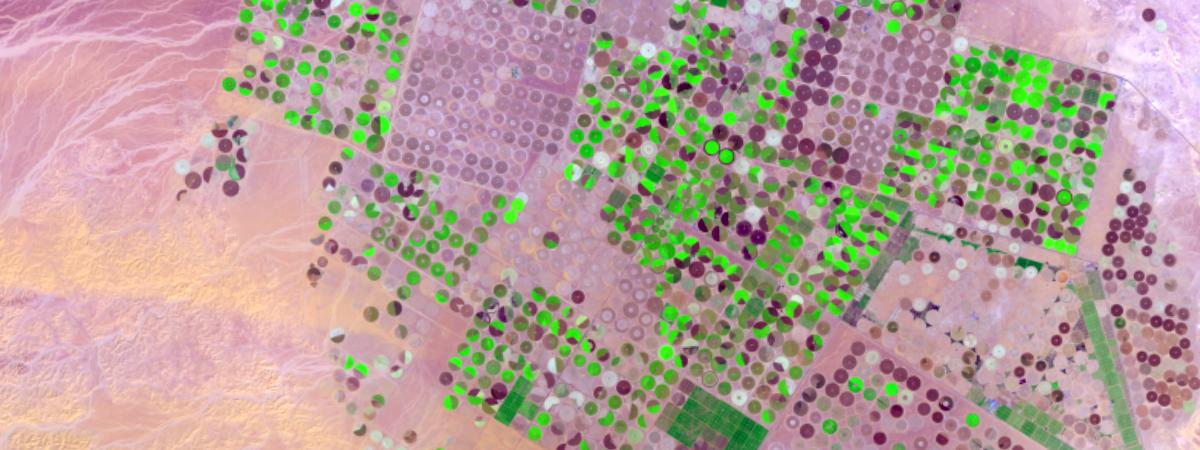

In [7]:
l8lyr.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmax': 4296559.143733407,
                                         'xmin': 4219969.241391764,
                                         'ymax': 3522726.823081019,
                                         'ymin': 3492152.0117669892}
l8lyr

We can preprocess the imagery using raster functions. The code below uses the ndvi raster function to identify areas that have healthy vegetation. This preprocessing step makes the scikit-image blob detection algorithm work better.

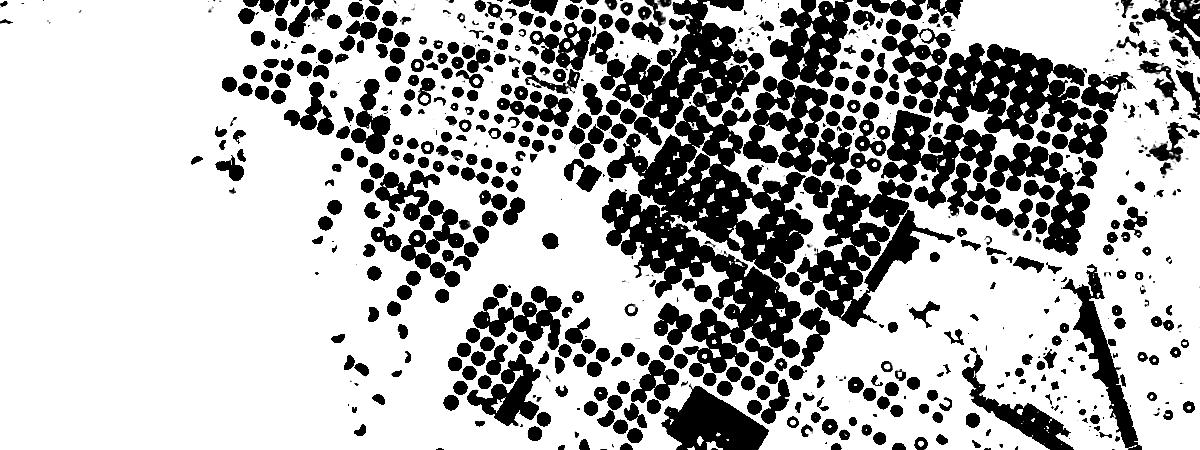

In [8]:
from arcgis.raster.functions import ndvi, stretch
stretch(ndvi(l8lyr), stretch_type='PercentClip', min_percent=30, max_percent=70, dra=True)

In [9]:
img = stretch(ndvi(l8lyr), stretch_type='PercentClip', min_percent=30, max_percent=70, dra=True).export_image(bbox=l8lyr.extent, bbox_sr=102100, size=[1200, 450],
                       export_format='jpeg', save_folder='.', save_file='centerpivotfarms.jpg', f='image')

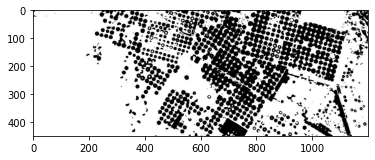

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('centerpivotfarms.jpg')

# what does it look like?
plt.imshow(img)
plt.show()

/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/usr/local/lib/python3.6/dist-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


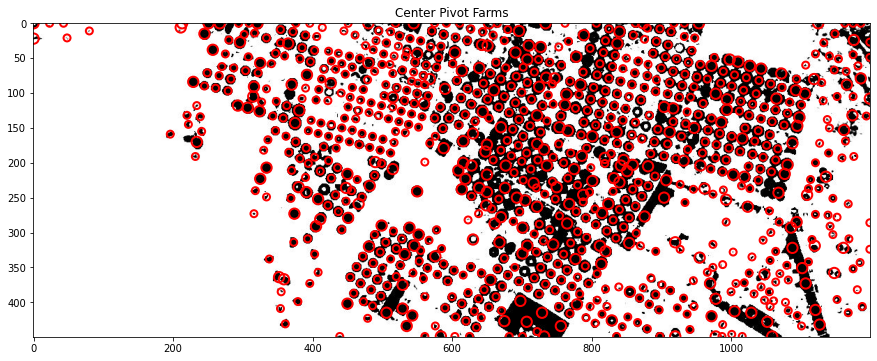

Number of center pivot farms detected: 898


In [11]:
from skimage import feature, color
import matplotlib.pyplot as plt
bw = img.mean(axis=2)

fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1)

blobs_dog = [(x[0],x[1],x[2]) for x in feature.blob_dog(-bw, 
                                                        min_sigma=4, 
                                                        max_sigma=8,
                                                        threshold=0.1,
                                                        overlap=0.6)]

#remove duplicates
blobs_dog = set(blobs_dog)

img_blobs = color.gray2rgb(img)

for blob in blobs_dog:
    y, x, r = blob
    c = plt.Circle((x, y), r+1, color='red', linewidth=2, fill=False)
    ax.add_patch(c)

plt.imshow(img_blobs)
plt.title('Center Pivot Farms')

plt.show()
print('Number of center pivot farms detected: ' + str(len(blobs_dog)))